In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [3]:
import os
import shutil

# Define the source and destination directories
source_dir = 'cats_and_dogs/test'
destination_dir = 'cats_and_dogs/test/test_folder'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Get a list of all the image files in the source directory
image_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

# Move each image file from the source directory to the destination directory
for image_file in image_files:
    source_path = os.path.join(source_dir, image_file)
    destination_path = os.path.join(destination_dir, image_file)
    shutil.move(source_path, destination_path)

print("All images moved successfully.")

All images moved successfully.


In [4]:
# 3 - Data Augmentation and Preprocessing:
# Data augmentation is a technique used to increase the diversity of the training dataset
# by applying various transformations like rotation, zoom, and flipping to the images.
# Here, we are using the ImageDataGenerator class to perform data augmentation and rescale the pixel values.
train_image_generator = ImageDataGenerator(rescale=1.0/255.0)
validation_image_generator = ImageDataGenerator(rescale=1.0/255.0)
test_image_generator = ImageDataGenerator(rescale=1.0/255.0)

# Generating Training Data:
# We create a data generator for the training set using the flow_from_directory method.
# It takes the path to the directory containing the training images, target_size (resizing images to a fixed size),
# batch_size (number of images in each batch), class_mode (binary, since we are using binary classification),
# and color_mode (rgb, as we have color images).
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

# Generating Validation Data:
# Similarly, we create a data generator for the validation set using the flow_from_directory method.
# This generator is used during training to evaluate the model's performance on unseen data.
val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

# Generating Test Data:
# For the test set, we also create a data generator using the flow_from_directory method.
# However, we set class_mode to None, as we don't need labels for the test set.
# Additionally, shuffle is set to False to keep the original order of images in the test set.
test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    shuffle=False
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


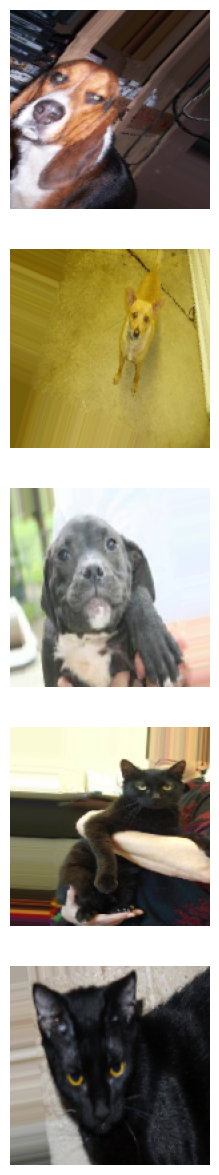

In [34]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [6]:
# 5 - Data Augmentation and Preprocessing:
# Data augmentation is a technique used to increase the diversity of the training dataset
# by applying various transformations like rotation, shift, shear, zoom, and flipping to the images.
# Here, we are using the ImageDataGenerator class to perform data augmentation and rescale the pixel values.
# The following parameters are used to control the augmentation:
# - rotation_range: Randomly rotates the image by a maximum of 40 degrees.
# - width_shift_range: Randomly shifts the image horizontally by a fraction of its width (20%).
# - height_shift_range: Randomly shifts the image vertically by a fraction of its height (20%).
# - shear_range: Applies shearing transformation with a maximum of 20% distortion.
# - zoom_range: Randomly zooms the image by a maximum of 20%.
# - horizontal_flip: Randomly flips the image horizontally.
# - fill_mode: The strategy used to fill newly created pixels after rotation or shifts ('nearest' in this case).
train_image_generator = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 2000 images belonging to 2 classes.


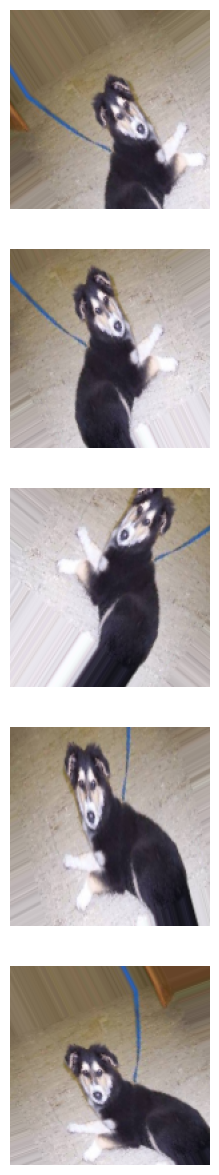

In [7]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [8]:
# 7 - Building the CNN Model:
# We are using a Sequential model, which is a linear stack of layers.
model = Sequential()

# Adding the first Convolutional layer:
# We use 32 filters of size 3x3 with the 'relu' activation function.
# The input shape is (150, 150, 3) representing the image dimensions (height, width, channels).
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))

# Adding the first MaxPooling layer:
# It performs downsampling by taking the maximum value from a 2x2 window.
model.add(MaxPooling2D((2, 2)))

# Adding the second Convolutional layer:
# Here, we use 64 filters of size 3x3 with the 'relu' activation function.
model.add(Conv2D(64, (3, 3), activation='relu'))

# Adding the second MaxPooling layer:
# Similar to the previous layer, it performs downsampling with a 2x2 window.
model.add(MaxPooling2D((2, 2)))

# Adding the third Convolutional layer:
# This time, we use 128 filters of size 3x3 with the 'relu' activation function.
model.add(Conv2D(128, (3, 3), activation='relu'))

# Adding the third MaxPooling layer:
# It performs downsampling using a 2x2 window.
model.add(MaxPooling2D((2, 2)))

# Flattening the output from the previous layer:
# This layer transforms the 3D feature maps to a 1D vector to be fed into the Dense layers.
model.add(Flatten())

# Adding a Dense layer with 256 neurons and the 'relu' activation function:
# This fully connected layer allows the model to learn complex patterns from the extracted features.
model.add(Dense(256, activation='relu'))

# Adding the final Dense layer with 1 neuron and the 'sigmoid' activation function:
# This neuron outputs a probability score representing the binary classification result.
model.add(Dense(1, activation='sigmoid'))

# Compiling the model:
# We use the 'adam' optimizer, 'binary_crossentropy' loss function for binary classification,
# and 'accuracy' as the evaluation metric.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Displaying the model summary:
# The summary provides an overview of the model architecture and the number of trainable parameters.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [13]:
# 8
train_steps_per_epoch = total_train // batch_size
val_steps_per_epoch = total_val // batch_size

history = model.fit(
    train_data_gen,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_data_gen,
    validation_steps=val_steps_per_epoch,
    epochs=2*epochs
)


Epoch 1/30
15/15 [==============================] - 15s 1s/step - loss: 0.5504 - accuracy: 0.7276 - val_loss: 0.5473 - val_accuracy: 0.7042
Epoch 2/30
15/15 [==============================] - 15s 987ms/step - loss: 0.5701 - accuracy: 0.6928 - val_loss: 0.5497 - val_accuracy: 0.7132
Epoch 3/30
15/15 [==============================] - 21s 1s/step - loss: 0.5518 - accuracy: 0.7244 - val_loss: 0.5248 - val_accuracy: 0.7277
Epoch 4/30
15/15 [==============================] - 15s 1s/step - loss: 0.5299 - accuracy: 0.7404 - val_loss: 0.5158 - val_accuracy: 0.7333
Epoch 5/30
15/15 [==============================] - 14s 972ms/step - loss: 0.5193 - accuracy: 0.7377 - val_loss: 0.4959 - val_accuracy: 0.7556
Epoch 6/30
15/15 [==============================] - 15s 1s/step - loss: 0.5438 - accuracy: 0.7217 - val_loss: 0.5902 - val_accuracy: 0.6775
Epoch 7/30
15/15 [==============================] - 15s 976ms/step - loss: 0.5238 - accuracy: 0.7436 - val_loss: 0.5165 - val_accuracy: 0.7433
Epoch 8/30


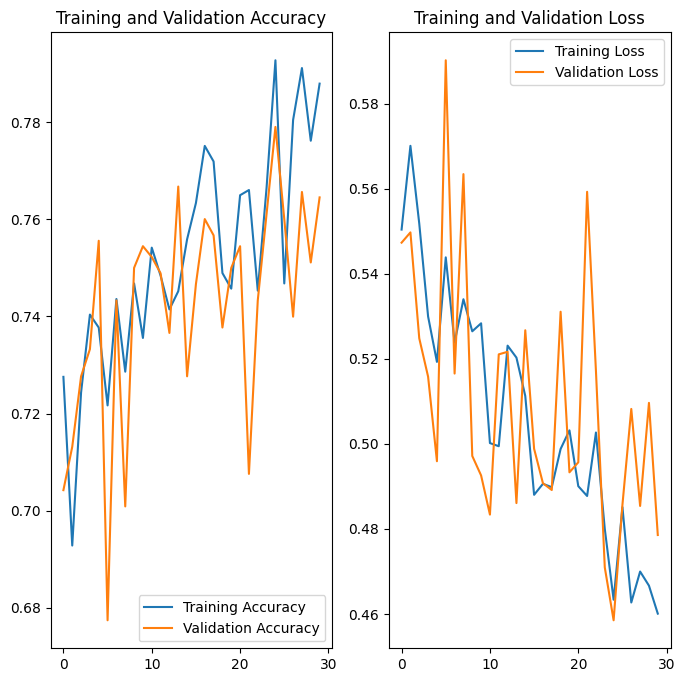

In [15]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(2*epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.evaluate(val_data_gen,
steps=val_steps_per_epoch)

7/7 [==============================] - 2s 223ms/step - loss: 0.4710 - accuracy: 0.7656


[0.4710083603858948, 0.765625]

1/1 [==============================] - 0s 145ms/step


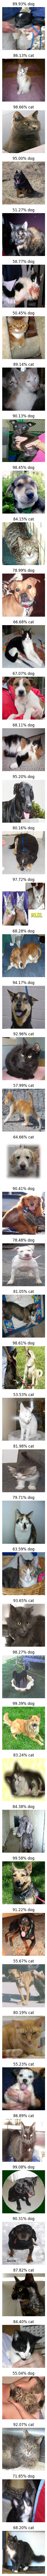

In [39]:
# 10
probabilities = model.predict(test_data_gen)

plotImages(next(test_data_gen), probabilities)

In [41]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 74.0% of the images of cats and dogs.
You passed the challenge!
